**In this notebook we experimented with different season partitioning.The results were poor though.**

In [4]:
library(lubridate)  #work with dates
library(xts)
library(forecast)
lct <- Sys.getlocale("LC_TIME"); Sys.setlocale("LC_TIME", "C") #needed for as.POSIXct

[1] "C"

In [5]:
data <- read.csv('bicup2006.csv',sep=',')
head(data)
dim(data)

DATE,TIME,DEMAND
1-Mar-05,6:30,1
1-Mar-05,6:45,2
1-Mar-05,7:00,4
1-Mar-05,7:15,0
1-Mar-05,7:30,10
1-Mar-05,7:45,13


[1] 1512    3

In [41]:
daytype<-rep("weekday",1512)
daytype[253:378]<-"weekend"
daytype[694:819]<-"weekend"
daytype[1135:1260]<-"weekend"
dtype<-rep(1,1512)
dtype[which(daytype=="weekend")]<-0


myseason<-rep(c(rep(1,16),rep(2,16),rep(3,15),rep(4,16)),24)

In [42]:
date.and.time<-paste(data$DATE,data$TIME) #combine date and time in one column
posix.date<-as.POSIXct(date.and.time,format="%d-%b-%y %H:%M")
#create new dataframe with columns posix.date and demand
newdata<-data.frame(posix.date,data$DEMAND,daytype,myseason,dtype)
names(newdata)<-c('date.and.time','demand','daytype','myseason','dtype')
head(newdata)
dim(newdata)

date.and.time,demand,daytype,myseason,dtype
2005-03-01 06:30:00,1,weekday,1,1
2005-03-01 06:45:00,2,weekday,1,1
2005-03-01 07:00:00,4,weekday,1,1
2005-03-01 07:15:00,0,weekday,1,1
2005-03-01 07:30:00,10,weekday,1,1
2005-03-01 07:45:00,13,weekday,1,1


[1] 1512    5

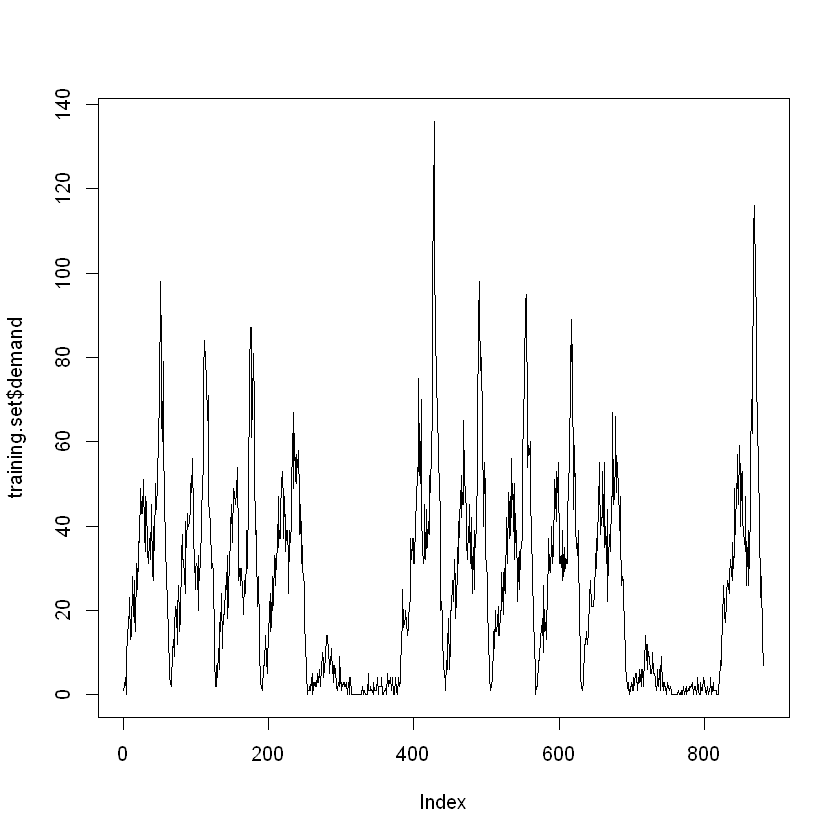

In [43]:
#indexes for first two weeks
training.set<-newdata[1:(14*63),]
#indexes for last week
validation.set<-newdata[((14*63)+1):(21*63),]
#indexes for last 3 days
future.set<-newdata[((21*63)+1):dim(newdata)[1],]
plot(training.set$demand,type='l')

In [44]:
newdata.xts = xts(coredata(newdata$demand), order.by=as.POSIXct(newdata$date.and.time))
attr(newdata.xts,"frequency")<-4
periodicity(newdata.xts)
total_timeseries<-as.ts(newdata.xts)

15 minute periodicity from 2005-03-01 06:30:00 to 2005-03-24 22:00:00 

In [45]:
#dummy vars
S1<-rep(0,1512)
S2<-rep(0,1512)
S3<-rep(0,1512)
S4<-rep(0,1512)
S1[which(myseason==1)]=1
S2[which(myseason==2)]=1
S3[which(myseason==3)]=1
S4[which(myseason==4)]=1

seasonal_data<-data.frame(newdata,S1,S2,S3,S4)

In [46]:
my.xts = xts(coredata(training.set$demand), order.by=as.POSIXct(training.set$date.and.time))
attr(my.xts,"frequency")<-4
periodicity(my.xts)
timeseries<-as.ts(my.xts)

15 minute periodicity from 2005-03-01 06:30:00 to 2005-03-14 22:00:00 

In [123]:
model<-tslm(timeseries ~ dtype[1:882] *(
            
  seasonal_data[1:882, 5+1 ]
  + seasonal_data[1:882, 5+2 ]
  + seasonal_data[1:882, 5+3 ]  )        
           )

summary(model)


Call:
tslm(formula = timeseries ~ dtype[1:882] * (seasonal_data[1:882, 
    5 + 1] + seasonal_data[1:882, 5 + 2] + seasonal_data[1:882, 
    5 + 3]))

Residuals:
    Min      1Q  Median      3Q     Max 
-45.831  -5.625  -0.692   5.319  87.169 

Coefficients:
                                         Estimate Std. Error t value Pr(>|t|)
(Intercept)                                1.7031     1.7844   0.954 0.340122
dtype[1:882]                              47.1281     2.1113  22.321  < 2e-16
seasonal_data[1:882, 5 + 1]               -0.4375     2.5235  -0.173 0.862403
seasonal_data[1:882, 5 + 2]                2.6250     2.5235   1.040 0.298533
seasonal_data[1:882, 5 + 3]                1.4969     2.5653   0.584 0.559695
dtype[1:882]:seasonal_data[1:882, 5 + 1] -34.7125     2.9859 -11.625  < 2e-16
dtype[1:882]:seasonal_data[1:882, 5 + 2] -11.8312     2.9859  -3.962 8.03e-05
dtype[1:882]:seasonal_data[1:882, 5 + 3] -11.8015     3.0353  -3.888 0.000109
                                      

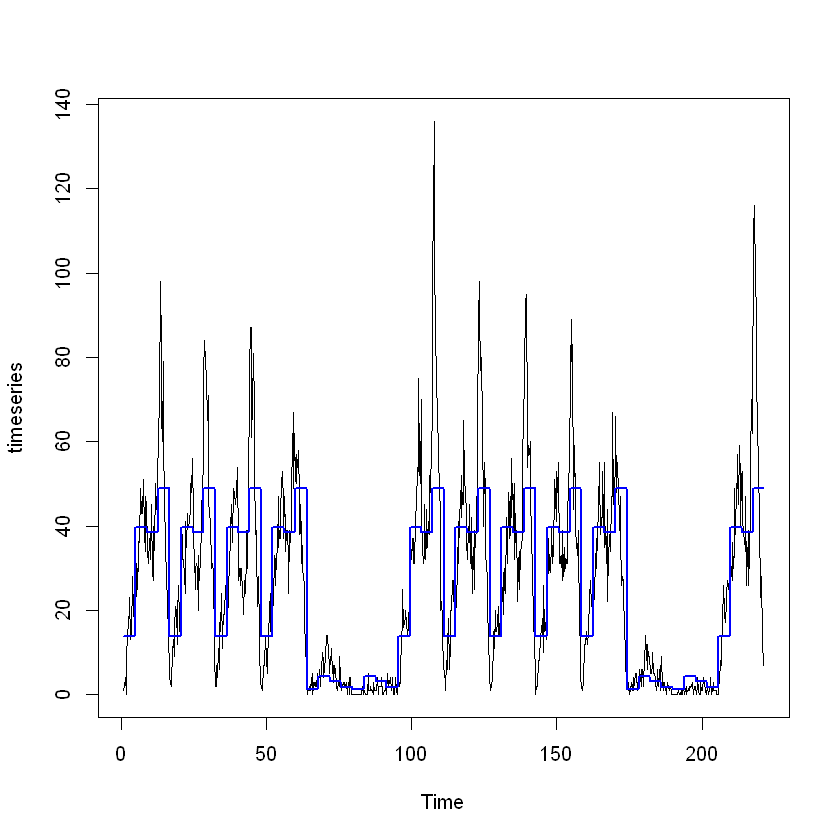

In [124]:
#coefficients(model)
coef<-coefficients(model)
plot(timeseries)
lines(model$fitted, lwd = 2,col='blue')

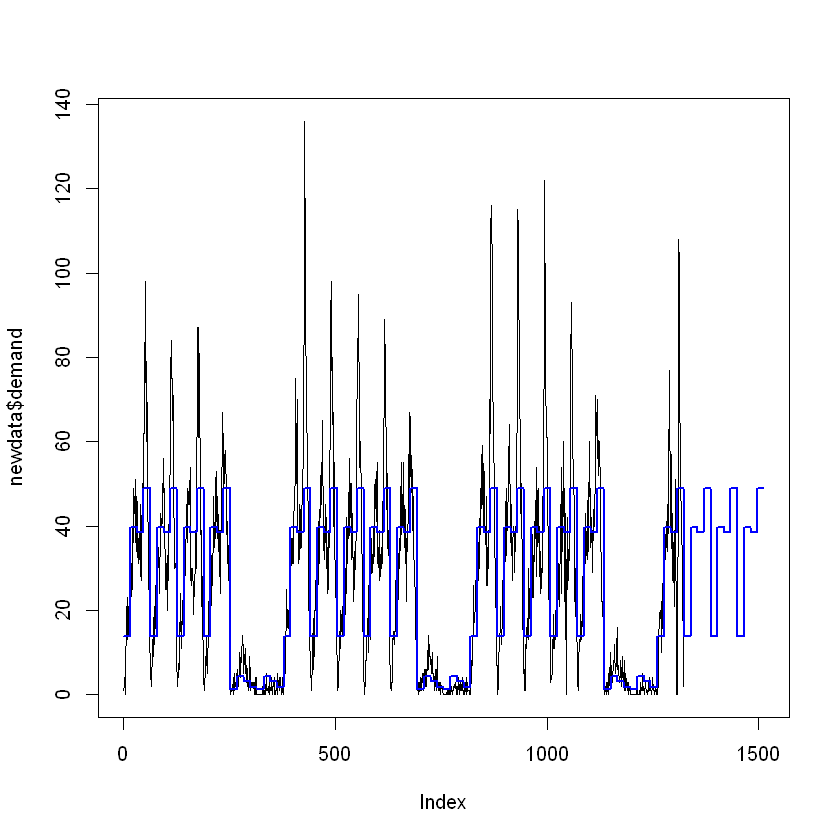

In [133]:
mymodel  = ( coef[1] + coef[2]*dtype + seasonal_data$S1*coef[3] + seasonal_data$S2*coef[4] + seasonal_data$S3*coef[5] 
 + dtype*(seasonal_data$S1*coef[6] + seasonal_data$S2*coef[7] + seasonal_data$S3*coef[8]))

plot(newdata$demand,type='l')
lines(mymodel,lwd = 2,col='blue')

In [185]:
modeldata<-data.frame(seasonal_data$demand,seasonal_data$dtype,seasonal_data[,6:8])
colnames(modeldata)<-c('demand','daytype',colnames(model_dataframe)[3:5])

multdata<-data.frame(modeldata$demand,modeldata$daytype,modeldata[,3:5],modeldata$daytype*modeldata[,3:5])
colnames(multdata)<-c('demand','daytype',colnames(modeldata)[3:5],paste(colnames(modeldata)[3:5],'.dtype',sep = ''))

trainingdata<-multdata[1:882,]
head(trainingdata)

demand,daytype,S1,S2,S3,S1.dtype,S2.dtype,S3.dtype
1,1,1,0,0,1,0,0
2,1,1,0,0,1,0,0
4,1,1,0,0,1,0,0
0,1,1,0,0,1,0,0
10,1,1,0,0,1,0,0
13,1,1,0,0,1,0,0


In [126]:
model<-lm(demand~.,trainingdata)

summary(model)


Call:
lm(formula = demand ~ ., data = trainingdata)

Residuals:
    Min      1Q  Median      3Q     Max 
-45.831  -5.625  -0.692   5.319  87.169 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.7031     1.7844   0.954 0.340122    
daytype      47.1281     2.1113  22.321  < 2e-16 ***
S1           -0.4375     2.5235  -0.173 0.862403    
S2            2.6250     2.5235   1.040 0.298533    
S3            1.4969     2.5653   0.584 0.559695    
S1.dtype    -34.7125     2.9859 -11.625  < 2e-16 ***
S2.dtype    -11.8312     2.9859  -3.962 8.03e-05 ***
S3.dtype    -11.8015     3.0353  -3.888 0.000109 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 14.28 on 874 degrees of freedom
Multiple R-squared:  0.6268,	Adjusted R-squared:  0.6238 
F-statistic: 209.7 on 7 and 874 DF,  p-value: < 2.2e-16


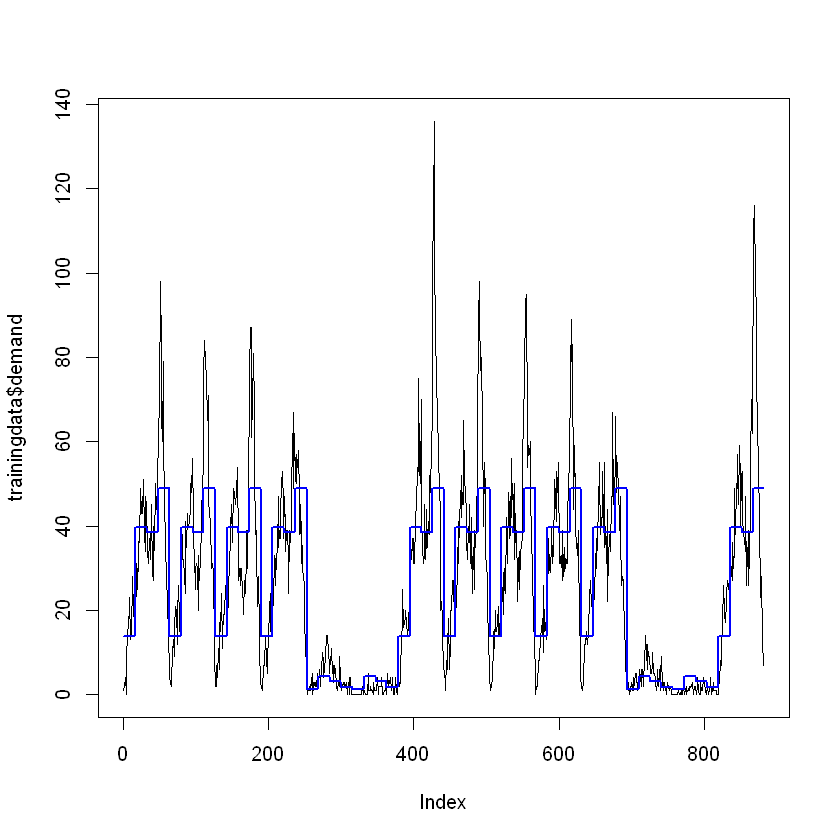

In [181]:
plot(trainingdata$demand,type='l')
lines(model$fitted, lwd = 2,col='blue')

In [191]:
#We create a new dataframe to make the model calculation easier below
ones<-rep(1,1512)
#we remove the demand column since thats what we predict and we replace it with ones
#so they are multiplied by the intercept coefficient
final.model.data<-data.frame(ones,multdata[,-1])


head(final.model.data)
dim(final.model.data)

ones,daytype,S1,S2,S3,S1.dtype,S2.dtype,S3.dtype
1,1,1,0,0,1,0,0
1,1,1,0,0,1,0,0
1,1,1,0,0,1,0,0
1,1,1,0,0,1,0,0
1,1,1,0,0,1,0,0
1,1,1,0,0,1,0,0


[1] 1512    8

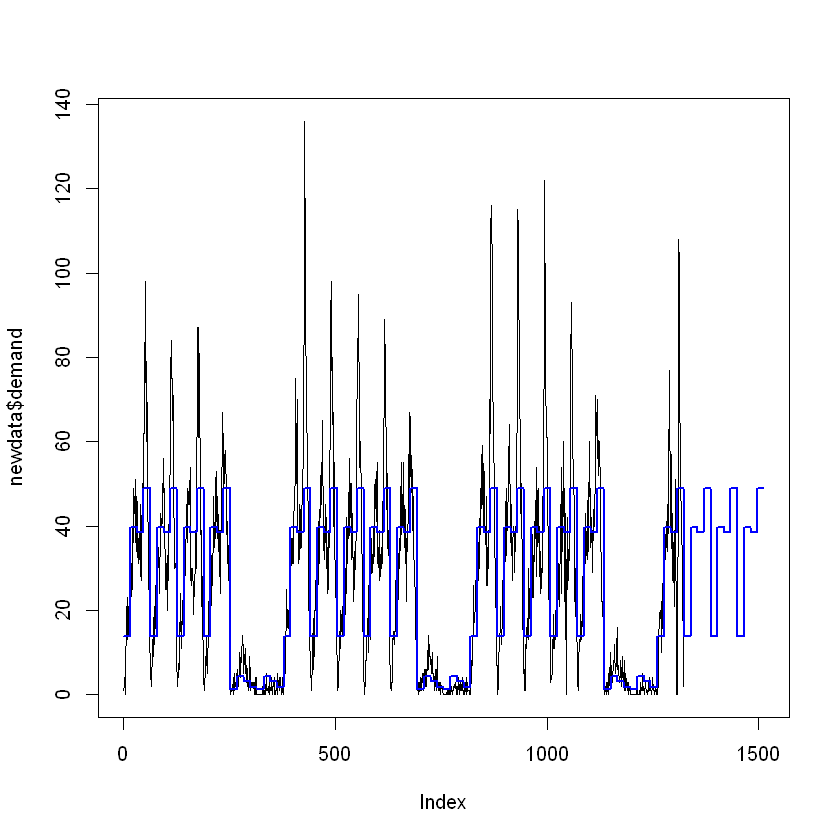

In [192]:
#coefficients(model)
coef<-coefficients(model)

mymodel = rowSums(mapply("*", as.data.frame(final.model.data),coef))

plot(newdata$demand,type='l')
lines(mymodel,lwd = 2,col='blue')